In [72]:
import pandas as pd
from statsmodels.tsa.seasonal import STL
from scipy import signal
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, kstest
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

## Чтение и визуализация временного ряда

In [56]:
test_file='C:/Users/Julia/Documents/ITMO/ITMO_master_degree_classes/Research_work(NEMO)/(2014)19.875_75.875.csv'
df=pd.read_csv(test_file, sep=';')
df['dates'] =  pd.to_datetime(df['dates'], format='%Y-%m-%d')
df=df[:-90]

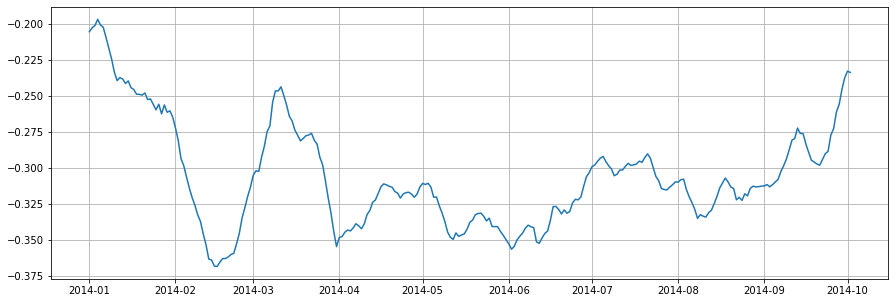

In [57]:
plt.rcParams['figure.figsize'] = [15, 5]
plt.plot(df['dates'], df['sea_level'])
plt.grid()
plt.show()

## Частотная оценка ряда

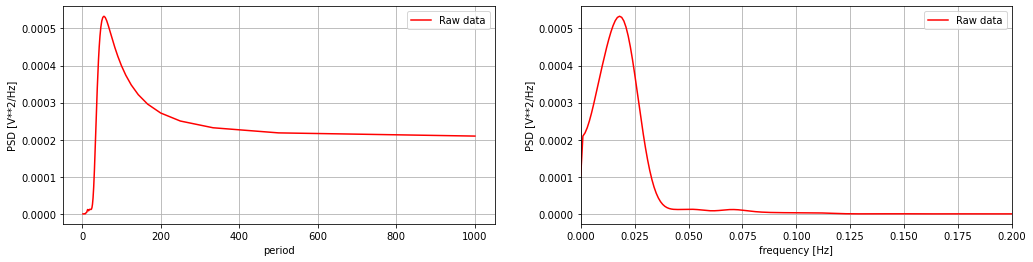

In [74]:
plt.rcParams['figure.figsize'] = [17, 4]

b_f, b_Pxx_den = signal.welch(df['sea_level'], fs=1, scaling='spectrum', nfft = 1000, nperseg=100)

plt.subplot(1, 2, 1)
plt.plot(1/b_f, b_Pxx_den, c='r', label='Raw data')
plt.grid()

plt.legend()
plt.xlabel('period')
plt.ylabel('PSD [V**2/Hz]')

plt.subplot(1, 2, 2)
plt.plot(b_f, b_Pxx_den, c='r', label='Raw data')
plt.xlim(0, 0.2)
plt.grid()
plt.legend()
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

# Похоже на 14 и 50 дней 

## Оценка цикличности и остатков

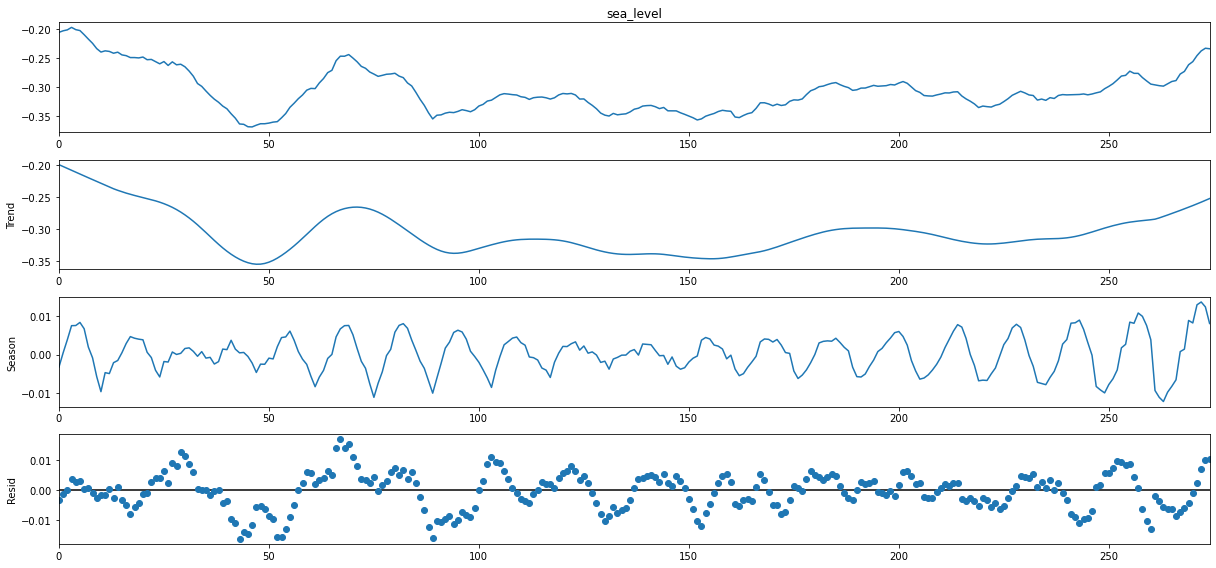

In [75]:
plt.rcParams['figure.figsize'] = [17, 8]
stl = STL(df['sea_level'], period=14)
res = stl.fit()
fig = res.plot()

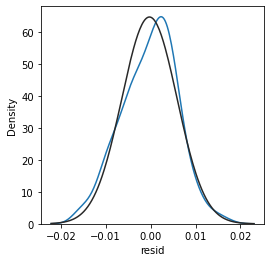

KstestResult(statistic=0.054547465607291845, pvalue=0.3730499431026254)


In [76]:
plt.rcParams['figure.figsize'] = [4, 4]
sns.distplot(res.resid, fit=norm, hist=False)
plt.show()
params = norm.fit(res.resid)
ks = kstest(res.resid, 'norm', params, N=1000)
print(ks)

## Моделирование ряда без остатков (т.к. у них нормальное распределение)

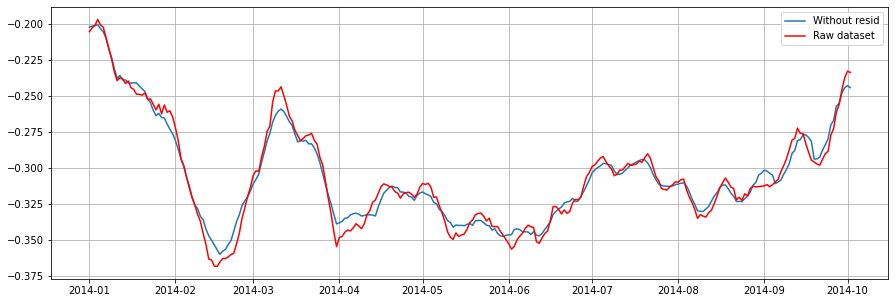

In [77]:
plt.rcParams['figure.figsize'] = [15, 5]
ds_no_resid=df['sea_level']-res.resid
df['sea_level_no_resid']=ds_no_resid
plt.plot(df['dates'], df['sea_level_no_resid'], label='Without resid')
plt.plot(df['dates'], df['sea_level'], c='r', label='Raw dataset')
plt.legend()
plt.grid()
plt.show()

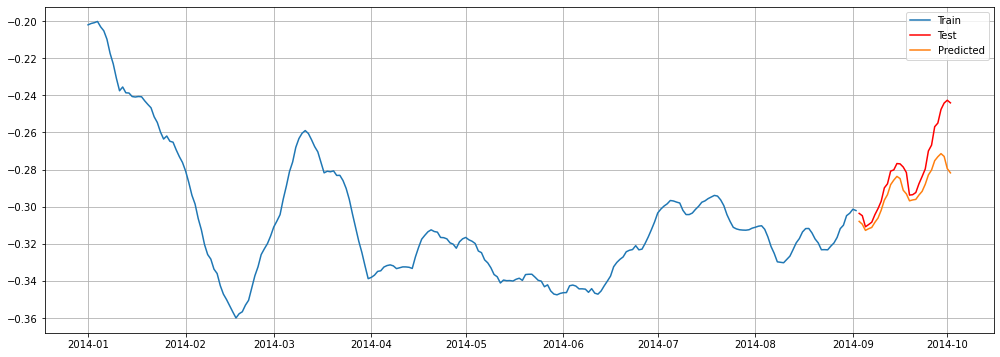

In [81]:
from statsmodels.tsa.api import STLForecast
from statsmodels.tsa.arima.model import ARIMA
plt.rcParams['figure.figsize'] = [17, 6]

test = df['sea_level_no_resid'][-30:]
test.index = df['dates'][-30:]
data = df['sea_level_no_resid'][:-30]
data.index = df['dates'][:-30]

stlf = STLForecast(data, ARIMA, period=14, model_kwargs={"order": (2, 1, 0)})
model_res = stlf.fit()
forecasts = model_res.forecast(30)
plt.rcParams['figure.figsize'] = [17, 6]
plt.plot(data, label='Train')
plt.plot(test, c='r', label='Test')
plt.plot(forecasts, label='Predicted')
plt.legend()
plt.grid()
plt.show()

## Ошибки модели

In [80]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

print("MSE = ", mean_squared_error(test, forecasts))
print("MAE = ", mean_absolute_error(test, forecasts))
print("MAPE = ", round(np.mean(np.abs(test-forecasts)/test)*100,3))
print("R^2 = ", r2_score(test, forecasts))

MSE =  0.0002023154907743423
MAE =  0.010531808884952143
MAPE =  -3.997
R^2 =  0.5059259407084156


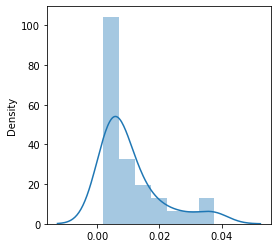

In [73]:
plt.rcParams['figure.figsize'] = [4, 4]
sns.distplot(test-forecasts)
plt.show()